<a href="https://colab.research.google.com/github/galacticism/Predicting-Recidivism-With-Machine-Learning-An-Analysis-of-Risk-Factors/blob/main/Recidivism%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pop2 = pd.read_csv('pop2.csv')

In [ ]:
nij = pd.read_csv('nij.csv')

In [ ]:
# Rename the 'PUMA' column in pop1 to 'Residence_PUMA' to match rec
pop2 = pop2.rename(columns={'PUMA': 'Residence_PUMA'})

# Explode the dataframe based on 'PWGTP' column
pop2 = pop2.loc[pop2.index.repeat(pop2['PWGTP'])].reset_index(drop=True)

In [ ]:
pop2_copy = pop2.copy()

# Define the new dataset
transformed_pop2 = pd.DataFrame(index=pop2_copy['Residence_PUMA'].unique())

# Calculate Disability Percentage for DIS
pop2_copy['Disability'] = pop2_copy['DIS'].apply(lambda x: 1 if x == 1 else 0)

disability_proportion = pop2_copy.groupby('Residence_PUMA')['Disability'].mean()

transformed_pop2['Disability_Percentage'] = disability_proportion

# Calculate Unemployment Percentage for ESR
pop2_copy['Unemployed'] = pop2_copy['ESR'].apply(lambda x: 1 if x in [3, 6] else 0)

unemployed_proportion = pop2_copy.groupby('Residence_PUMA')['Unemployed'].mean()

transformed_pop2['Unemployed_Percentage'] = unemployed_proportion

# Calculate Medicaid/Government Assistance Percentage for HINS4
pop2_copy['Govt_Assistance'] = pop2_copy['HINS4'].apply(lambda x: 1 if x == 1 else 0)

govt_assistance_proportion = pop2_copy.groupby('Residence_PUMA')['Govt_Assistance'].mean()

transformed_pop2['Govt_Assistance_Percentage'] = govt_assistance_proportion

# Calculate Education Level Percentages for SCHL
pop2_copy['No_HighSchool_Diploma'] = pop2_copy['SCHL'].apply(lambda x: 1 if x in list(range(1, 16)) else 0)
pop2_copy['HighSchool_Diploma'] = pop2_copy['SCHL'].apply(lambda x: 1 if x in [16, 17] else 0)
pop2_copy['Some_College_Degree'] = pop2_copy['SCHL'].apply(lambda x: 1 if x in list(range(18, 25)) else 0)

no_highschool_diploma_proportion = pop2_copy.groupby('Residence_PUMA')['No_HighSchool_Diploma'].mean()
highschool_diploma_proportion = pop2_copy.groupby('Residence_PUMA')['HighSchool_Diploma'].mean()
some_college_degree_proportion = pop2_copy.groupby('Residence_PUMA')['Some_College_Degree'].mean()

transformed_pop2['No_HighSchool_Diploma_Percentage'] = no_highschool_diploma_proportion
transformed_pop2['HighSchool_Diploma_Percentage'] = highschool_diploma_proportion
transformed_pop2['Some_College_Degree_Percentage'] = some_college_degree_proportion

In [ ]:
# Reset index for transformed_pop2
transformed_pop2_reset = transformed_pop2.reset_index()

# Rename the 'index' column to 'Residence_PUMA'
transformed_pop2_reset = transformed_pop2_reset.rename(columns={'index': 'Residence_PUMA'})

# Merge the datasets
merged_data = pd.merge(transformed_pop2_reset, nij, on='Residence_PUMA')

In [ ]:
merged_data.info()

**Drop all unnecessary columns**

In [ ]:
merged_data = merged_data.drop(['ID','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'], axis = 1)
merged_data = merged_data.drop(['Delinquency_Reports','Program_Attendances','Program_UnexcusedAbsences','Residence_Changes','Avg_Days_per_DrugTest'], axis = 1)
merged_data = merged_data.drop(['Supervision_Level_First', 'Training_Sample', 'Dependents','Prison_Offense'], axis = 1)

In [ ]:
# List of condition columns
condition_columns = ['Condition_MH_SA', 'Condition_Cog_Ed', 'Condition_Other']

# Create 'Disability Condition' column that is True if any condition is True (or 1), and False otherwise
merged_data['Disability Condition'] = merged_data[condition_columns].any(axis=1)

# Drop the original condition columns
merged_data = merged_data.drop(columns=condition_columns)

In [ ]:
# Get a list of all columns that start with 'DrugTests'
drug_test_columns = [col for col in merged_data.columns if col.startswith('DrugTests')]

# Sum these columns and create a new column 'DrugTests'
merged_data['DrugTests'] = merged_data[drug_test_columns].sum(axis=1)

# Drop the original 'DrugTests' columns
merged_data = merged_data.drop(columns=drug_test_columns)

In [ ]:
# Filter out the columns that represent prior arrests
prior_arrest_columns = [col for col in merged_data.columns if 'Prior_Arrest' in col]

# For the columns that are objects, we assume that 'number or more' is equivalent to 'number'
for column in prior_arrest_columns:
    if merged_data[column].dtype == 'object':
        merged_data[column] = merged_data[column].str.extract('(\d+)').astype(float)

# For the columns that are booleans, we convert True to 1 and False to 0
merged_data[prior_arrest_columns] = merged_data[prior_arrest_columns].astype(int)

# Combine the columns into a single 'Total_Prior_Arrests' column
merged_data['Total_Prior_Arrests'] = merged_data[prior_arrest_columns].sum(axis=1)

# Drop the original prior arrest columns
merged_data = merged_data.drop(prior_arrest_columns, axis=1)

In [ ]:
# Find all columns that start with "Prior_Convictions"
prior_convictions_cols = [col for col in merged_data.columns if 'Prior_Conviction' in col]

# For each of these columns
for column in prior_convictions_cols:
    # If the column data type is object
    if merged_data[column].dtype == 'object':
        # Extract the numerical part from the string
        merged_data[column] = merged_data[column].str.extract('(\d+)').astype(float)

# For the columns that are booleans, we convert True to 1 and False to 0
merged_data[prior_convictions_cols] = merged_data[prior_convictions_cols].astype(int)

# Combine the columns into a single 'Total_Prior_Arrests' column
merged_data['Total_Prior_Convictions'] = merged_data[prior_convictions_cols].sum(axis=1)

# Drop the original prior arrest columns
merged_data = merged_data.drop(prior_convictions_cols, axis=1)

In [ ]:
# Convert boolean columns to integers
merged_data = merged_data.astype({col: 'int' for col in merged_data.columns if col.startswith('Violations') or col.startswith('Prior_Revocations')})

# Get a list of all columns that start with 'Violations' or 'Prior_Revocations'
violation_and_revocation_columns = [col for col in merged_data.columns if col.startswith('Violations') or col.startswith('Prior_Revocations')]

# Sum these columns and create a new column 'Violations_and_Revocations'
merged_data['Violations_and_Revocations'] = merged_data[violation_and_revocation_columns].sum(axis=1)

# Drop the original 'Violations' and 'Prior_Revocations' columns
merged_data = merged_data.drop(columns=violation_and_revocation_columns)

**Convert everything to numerical format and remove null values**

In [ ]:
merged_data['Gender'] = merged_data['Gender'].replace({'M': 0, 'F': 1})
merged_data['Race'] = merged_data['Race'].replace({'BLACK': 0, 'WHITE': 1})
merged_data['Education_Level'] = merged_data['Education_Level'].replace({'Less than HS diploma':2, 'High School Diploma':1, 'At least some college':0})
merged_data['Prison_Years'] = merged_data['Prison_Years'].replace({'More than 3 years':6, '1-2 years':1.5, 'Less than 1 year':.5, 'Greater than 2 to 3 years':2.5})
merged_data['Percent_Days_Employed'] = 1 - merged_data['Percent_Days_Employed']

In [ ]:
# Convert 'Employment_Exempt' to integer
merged_data['Employment_Exempt'] = merged_data['Employment_Exempt'].astype(int)

# Convert 'Disability Condition' to integer
merged_data['Disability Condition'] = merged_data['Disability Condition'].astype(int)

# Convert 'Gang_Affiliated' to integer
merged_data['Gang_Affiliated'] = merged_data['Gang_Affiliated'].apply(lambda x: 1 if x == True else 0)

In [ ]:
def convert_age_range_to_midpoint(age_range):
    if age_range == '48 or older':
        return 60
    else:
        lower, upper = map(int, age_range.split('-'))
        return (lower + upper) / 2

# Apply the function to the 'Age_at_Release' column
merged_data['Age_at_Release'] = 78 - merged_data['Age_at_Release'].apply(convert_age_range_to_midpoint)

In [ ]:
# Drop rows with any null values
merged_data = merged_data.dropna()

**Combine Individual and Community Characteristics into one Similarity Column**

In [ ]:
# Create new column 'Disability_Similarity'
conditions = [
    (merged_data['Disability Condition'] == True),
    (merged_data['Disability Condition'] == False)
]
choices = [merged_data['Disability_Percentage'], 1-merged_data['Disability_Percentage']]
merged_data['Disability_Similarity'] = np.select(conditions, choices, default=0)
merged_data = merged_data.drop(['Disability Condition','Disability_Percentage'], axis = 1)

In [ ]:
def calculate_education_similarity(row):
    if row['Education_Level'] == 2:  # 'Less than HS diploma'
        return row['No_HighSchool_Diploma_Percentage']
    elif row['Education_Level'] == 1:  # 'High School Diploma'
        # Add the percentages of 'Less than HS diploma' and 'High School Diploma'
        return row['No_HighSchool_Diploma_Percentage'] + row['HighSchool_Diploma_Percentage']
    elif row['Education_Level'] == 0:  # 'At least some college'
        # Add the percentages of all education levels
        return row['No_HighSchool_Diploma_Percentage'] + row['HighSchool_Diploma_Percentage'] + row['Some_College_Degree_Percentage']

# Create 'Education_Similarity' column
merged_data['Education_Similarity'] = merged_data.apply(calculate_education_similarity, axis=1)
merged_data = merged_data.drop(['No_HighSchool_Diploma_Percentage', 'HighSchool_Diploma_Percentage', 'Some_College_Degree_Percentage'], axis=1)

In [ ]:
# Create new column 'Govt_Assisted_Similarity' only for 'Employment_Exempt' == True
conditions = [
    (merged_data['Employment_Exempt'] == 1),
    (merged_data['Employment_Exempt'] == 0)
]
choices = [merged_data['Govt_Assistance_Percentage'], 1-merged_data['Govt_Assistance_Percentage']]
merged_data['Govt_Assisted_Similarity'] = np.select(conditions, choices, default=np.nan)

# Drop the original columns 'Employment_Exempt' and 'Govt_Assistance_Percentage'
merged_data = merged_data.drop(['Employment_Exempt','Govt_Assistance_Percentage'], axis = 1)

In [ ]:
# Create new column 'Employment_Similarity'
conditions = [
    (merged_data['Percent_Days_Employed'] == 0),
    (merged_data['Percent_Days_Employed'] != 0)
]
choices = [merged_data['Unemployed_Percentage'], 1-merged_data['Unemployed_Percentage']]
merged_data['Employment_Similarity'] = np.select(conditions, choices, default=np.nan)
merged_data = merged_data.drop(['Unemployed_Percentage'], axis = 1)

In [ ]:
merged_data = merged_data.drop(['Residence_PUMA'], axis = 1)

In [ ]:
merged_data = pd.read_csv('merged_data1.csv')

**Find Correlations of each variable to Recidivism**

In [ ]:
corr=merged_data.corr()
corr['Recidivism_Within_3years']

Unnamed: 0                     -0.003354
Residence_PUMA                  0.025782
POVPIP                          0.001992
Gender                         -0.095860
Race                           -0.031769
Age_at_Release                  0.157128
Gang_Affiliated                 0.181733
Supervision_Risk_Score_First    0.175752
Education_Level                 0.086131
Prison_Offense                  0.014079
Prison_Years                   -0.104218
Percent_Days_Employed           0.266908
Jobs_Per_Year                  -0.048420
Recidivism_Within_3years        1.000000
DrugTests                       0.123165
Prior_Arrest_Episodes           0.076207
Prior_Conviction_Episodes       0.098479
Violations_and_Revocations      0.079877
Disability_Similarity          -0.060333
Education_Similarity            0.072138
Govt_Assisted_Similarity        0.050103
Employment_Similarity           0.136220
Age_Similarity                  0.048374
Name: Recidivism_Within_3years, dtype: float64

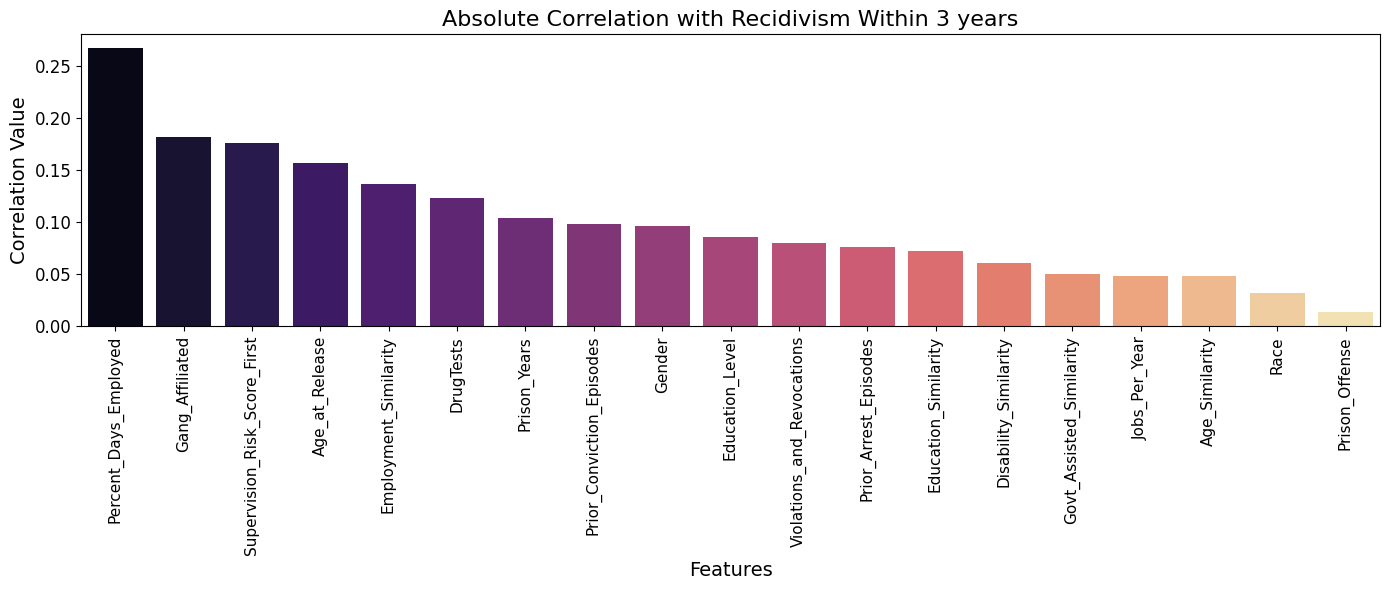

In [ ]:
# Calculate the absolute correlation with the target
corr = merged_data.corr()
absolute_correlation_with_target = corr['Recidivism_Within_3years'].abs()

# Remove specified columns
columns_to_remove = ["POVPIP", "Unnamed: 0", "Recidivism_Within_3years", "Residence_PUMA"]
absolute_correlation_with_target = absolute_correlation_with_target.drop(columns_to_remove)

# Sort correlations in descending order
sorted_correlation = absolute_correlation_with_target.sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x=sorted_correlation.index, y=sorted_correlation.values, palette="magma")
plt.title('Absolute Correlation with Recidivism Within 3 years', fontsize=16)
plt.ylabel('Correlation Value', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(rotation=90, fontsize=11)  # Rotate x labels for readability
plt.tight_layout()

plt.show()

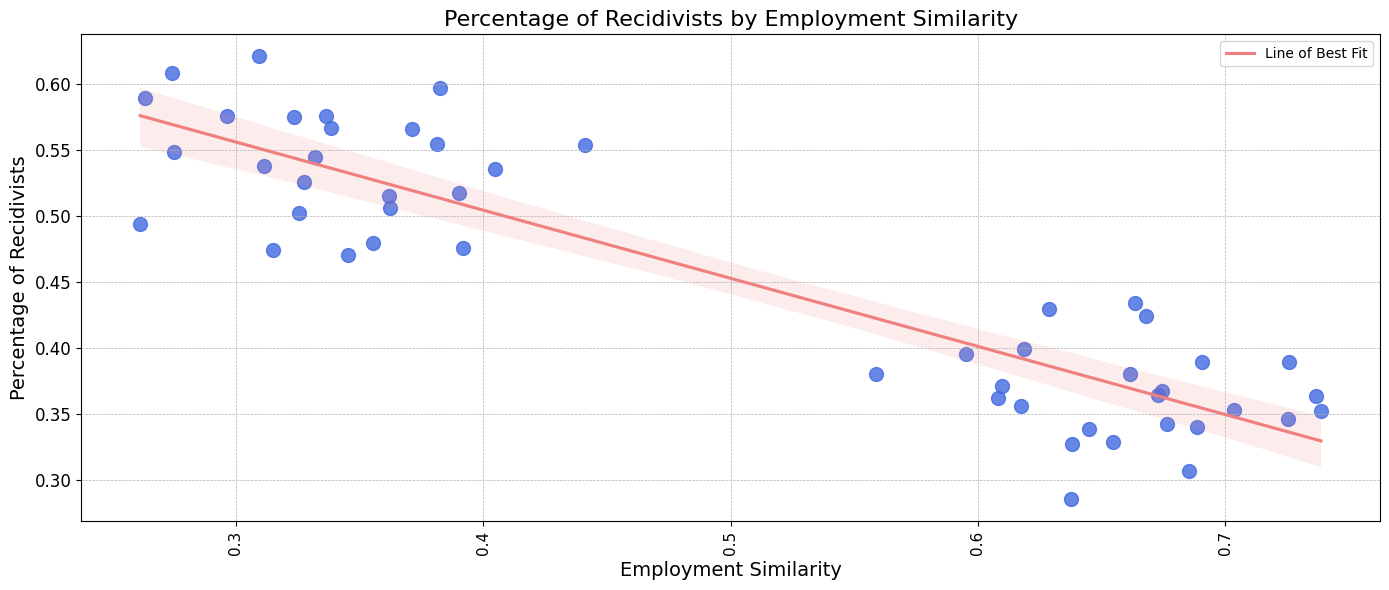

In [ ]:
# Group by 'Employment_Similarity' and calculate the mean of 'Recidivism_Within_3years'
recidivism_rate = merged_data.groupby('Employment_Similarity')['Recidivism_Within_3years'].mean()

# Calculate 1 minus the recidivism rate values for the y-axis
adjusted_recidivism_rate = 1 - recidivism_rate

# Scatterplot with regression line (line of best fit)
plt.figure(figsize=(14, 6))
sns.regplot(x=adjusted_recidivism_rate.index, y=adjusted_recidivism_rate.values, color="royalblue", scatter_kws={'s':100}, line_kws={'color':'lightcoral', 'label':'Line of Best Fit'})
plt.title('Percentage of Recidivists by Employment Similarity', fontsize=16)
plt.ylabel('Percentage of Recidivists', fontsize=14)
plt.xlabel('Employment Similarity', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(rotation=90, fontsize=11)  # Rotate x labels for readability
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

plt.show()


**Decision Tree Model**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [ ]:
# Convert 'Recidivism_Within_3years' to integer (1 for True, 0 for False)
merged_data['Recidivism_Within_3years'] = merged_data['Recidivism_Within_3years'].astype(int)

In [ ]:
# Define the target variable (y) and feature variables (X)
y = merged_data['Recidivism_Within_3years']
X = merged_data.drop(['Recidivism_Within_3years'], axis=1)  # here we are using all other columns as features

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=25)

In [ ]:
# Create and train the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

In [ ]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7069043525472808


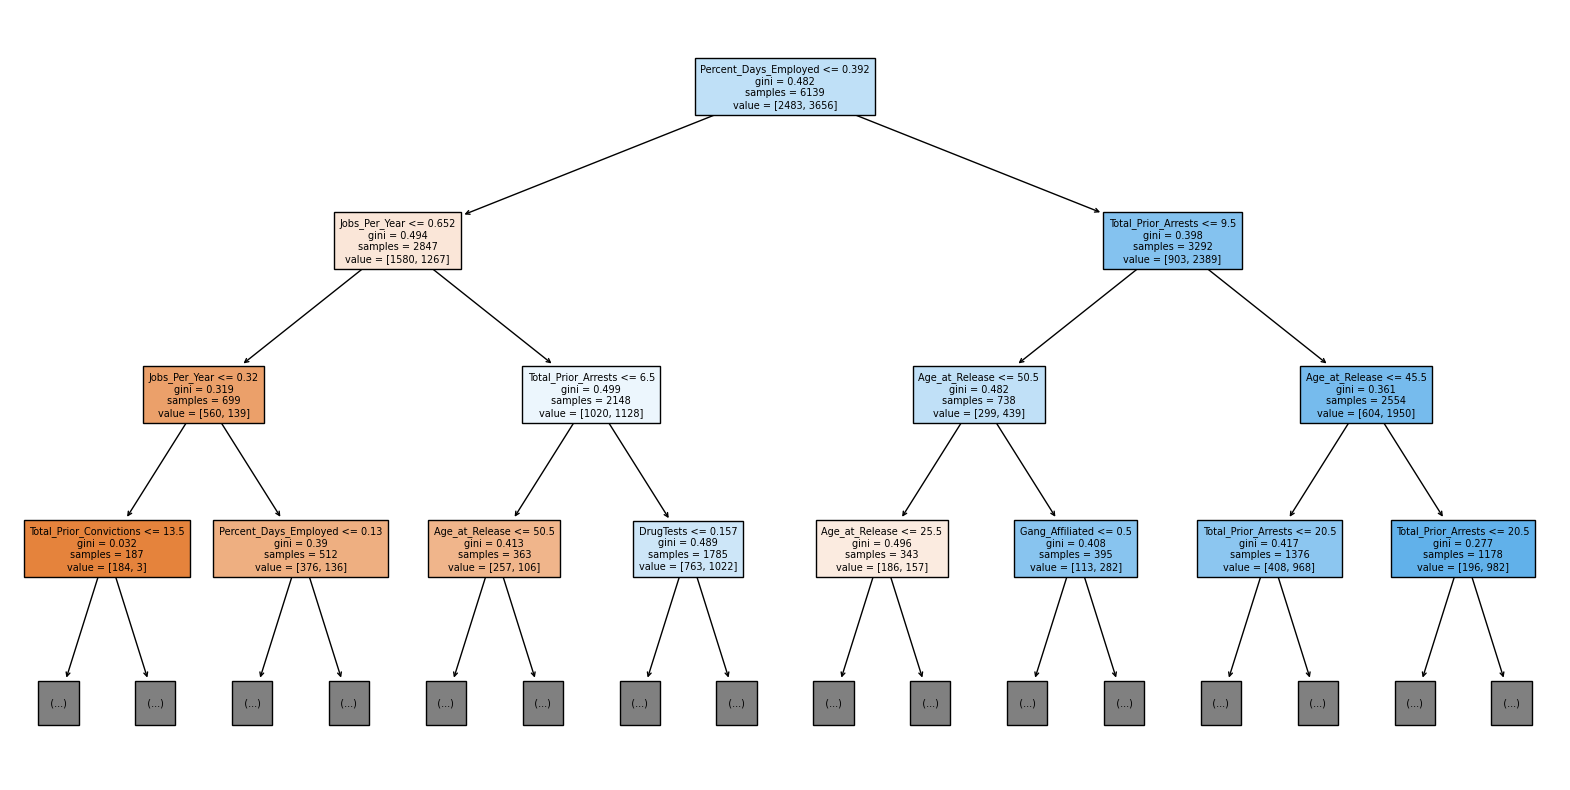

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, max_depth=3, fontsize = 7)
plt.show()

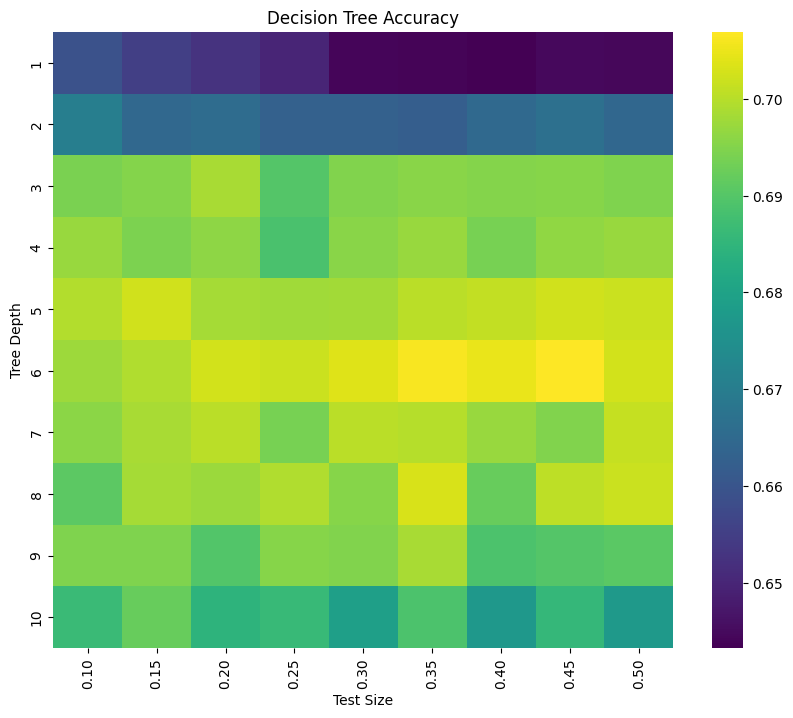

In [ ]:
# Define the range of split sizes and tree depths to test
split_sizes = np.linspace(0.1, 0.5, 9)
tree_depths = list(range(1, 11))

# Initialize a matrix to hold the accuracies
accuracy_matrix = np.zeros((len(split_sizes), len(tree_depths)))

for i, split_size in enumerate(split_sizes):
    for j, tree_depth in enumerate(tree_depths):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=25)
        clf = DecisionTreeClassifier(max_depth=tree_depth, random_state=25)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy_matrix[i, j] = accuracy_score(y_test, y_pred)

# Convert the accuracy matrix to a DataFrame for easier plotting
# Transpose the accuracy matrix here
accuracy_df = pd.DataFrame(accuracy_matrix.T, index=tree_depths, columns=split_sizes)

# Create a heatmap of the accuracies
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_df, cmap='viridis')
plt.title('Decision Tree Accuracy')
plt.ylabel('Tree Depth')
plt.xlabel('Test Size')

# Get the current figure for further editing
fig = plt.gcf()
ax = fig.gca()

# Modify x-axis labels to show only the first two digits
labels = [f'{size:.2f}' for size in split_sizes]
ax.set_xticklabels(labels)

# Show the plot
plt.show()

**Validation Testing**

In [ ]:
# Define the target variable and the feature set
y = merged_data['Recidivism_Within_3years']
X = merged_data.drop(['Recidivism_Within_3years'], axis=1)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=25)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=25)

In [ ]:
# Initialize the decision tree classifier
clf = DecisionTreeClassifier(max_depth=7)
# Train the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [ ]:
# Validate the model
y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')

Validation Accuracy: 0.7131378935939197


In [ ]:
# Test the model
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.6988599348534202


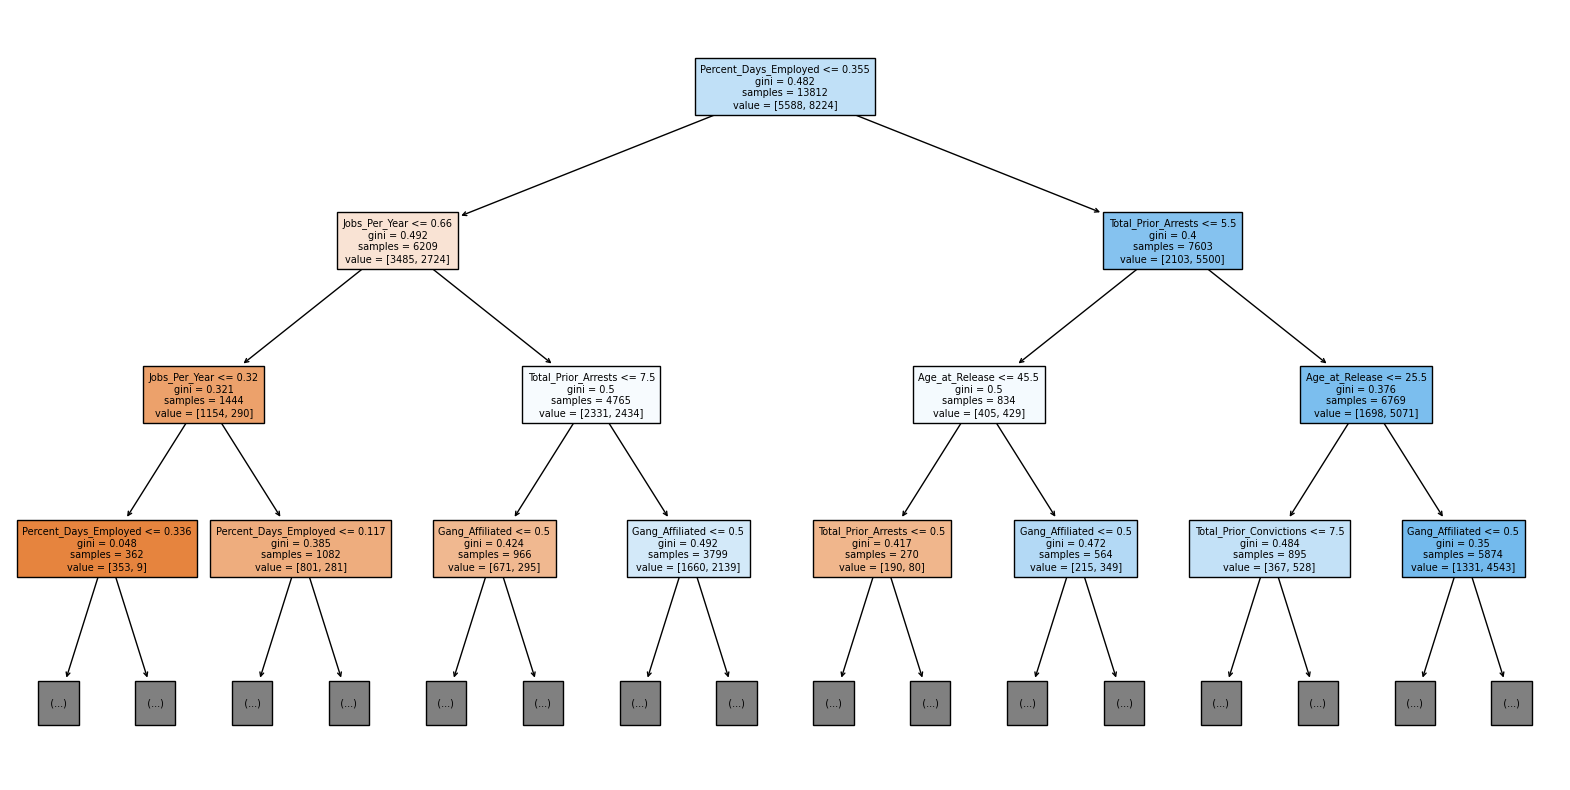

In [ ]:
# Plot the decision tree
plt.figure(figsize=(20, 10))  # Set the figure size
plot_tree(clf, filled=True, feature_names=X.columns, max_depth=3, fontsize = 7)
plt.show()

<ipython-input-100-e346408c2c35>:48: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  accuracy_df_wide_average = accuracy_df.pivot('Max Depth', 'Split Size', 'Average Accuracy')


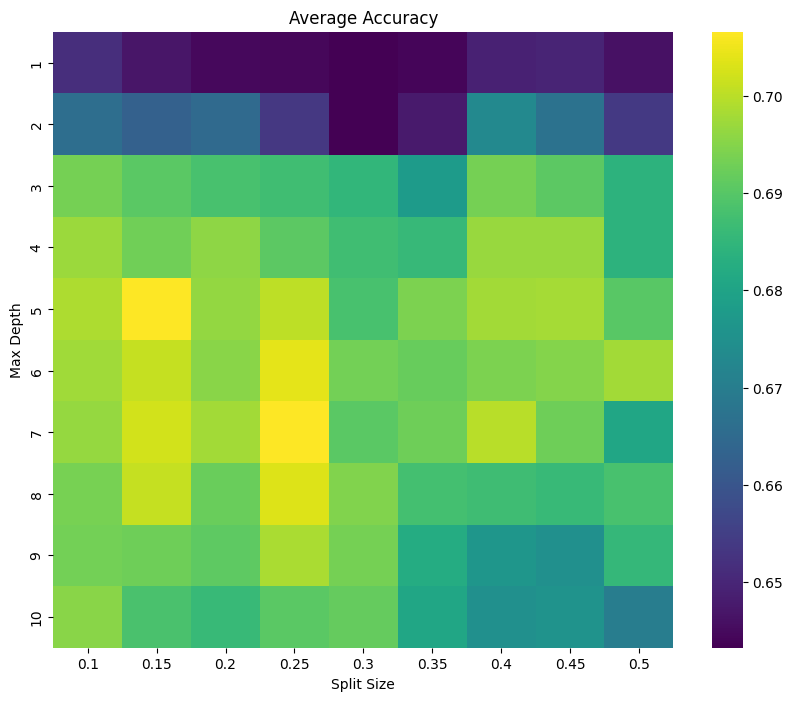

In [ ]:
# Initialize a dictionary to store the accuracies
accuracy_dict = {}

# Define the split sizes to be tested
split_sizes = np.around(np.linspace(0.1, 0.5, 9), decimals=2)

# Define the maximum depth values
max_depths = list(range(1, 11))

# For each split size and maximum depth
for split_size in split_sizes:
    for max_depth in max_depths:
        # Perform the first split
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=split_size, random_state=25)

        # Perform the second split
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=split_size, random_state=25)

        # Train a decision tree classifier
        clf = DecisionTreeClassifier(max_depth=max_depth, random_state=25)
        clf.fit(X_train, y_train)

        # Predict on the validation set
        y_val_pred = clf.predict(X_val)

        # Compute the accuracy on the validation set
        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Predict on the test set
        y_test_pred = clf.predict(X_test)

        # Compute the accuracy on the test set
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Store the accuracies
        accuracy_dict[(split_size, max_depth)] = (val_accuracy, test_accuracy)

# Convert the accuracy dictionary to a DataFrame for easier plotting
accuracy_df = pd.DataFrame(accuracy_dict, index=['Validation Accuracy', 'Test Accuracy']).T.reset_index()

# Rename the columns
accuracy_df.columns = ['Split Size', 'Max Depth', 'Validation Accuracy', 'Test Accuracy']

# Add a column for the average accuracy
accuracy_df['Average Accuracy'] = (accuracy_df['Validation Accuracy'] + accuracy_df['Test Accuracy']) / 2

# Reshape the DataFrame to wide format for the heatmap
accuracy_df_wide_average = accuracy_df.pivot('Max Depth', 'Split Size', 'Average Accuracy')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_df_wide_average, cmap='viridis')
plt.title('Average Accuracy')
plt.xlabel('Split Size')
plt.ylabel('Max Depth')
plt.show()

**Random Forest Algorithm**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn import tree

In [ ]:
# Define the target variable and the feature set
y = merged_data['Recidivism_Within_3years']
X = merged_data.drop(['Recidivism_Within_3years'], axis=1)

In [ ]:
# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=25)

In [ ]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=25)
# Train the classifier
clf.fit(X_train, y_train)
# Make predictions on the test set
y_test_pred = clf.predict(X_test)

In [ ]:
# Evaluate the model
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Test Accuracy:  0.7288273615635179

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.54      0.62      1483
           1       0.73      0.86      0.79      2201

    accuracy                           0.73      3684
   macro avg       0.73      0.70      0.70      3684
weighted avg       0.73      0.73      0.72      3684


Confusion Matrix:
 [[ 803  680]
 [ 319 1882]]


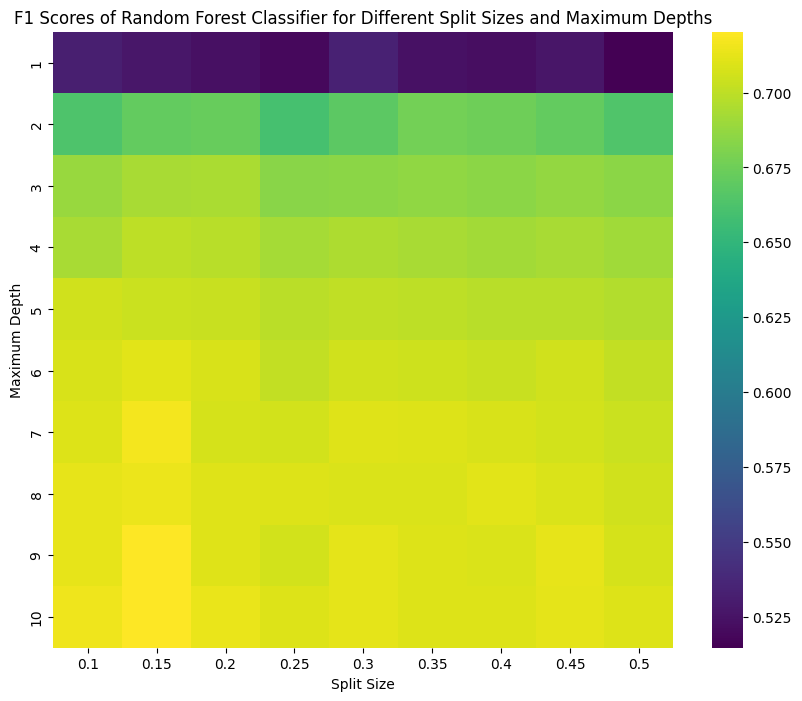

In [ ]:
# Define the split sizes and max depths to be tested
split_sizes = np.around(np.linspace(0.1, 0.5, 9), decimals=2)
max_depths = list(range(1, 11))

# Initialize a dictionary to store the F1 scores
f1_scores = {}

# For each split size
for split_size in split_sizes:
    f1_scores[split_size] = []

    # For each max depth
    for max_depth in max_depths:
        # Perform the split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=25)

        # Train a Random Forest classifier
        clf = RandomForestClassifier(max_depth=max_depth, random_state=25)
        clf.fit(X_train, y_train)

        # Predict on the test set
        y_test_pred = clf.predict(X_test)

        # Compute the F1 score on the test set
        f1 = f1_score(y_test, y_test_pred, average='weighted')

        # Store the F1 score
        f1_scores[split_size].append(f1)

# Convert the F1 scores to a DataFrame
f1_df = pd.DataFrame(f1_scores, index=max_depths)

# Create a heatmap of the F1 scores
plt.figure(figsize=(10, 8))
sns.heatmap(f1_df, cmap='viridis')
plt.xlabel('Split Size')
plt.ylabel('Maximum Depth')
plt.title('F1 Scores of Random Forest Classifier for Different Split Sizes and Maximum Depths')
plt.show()

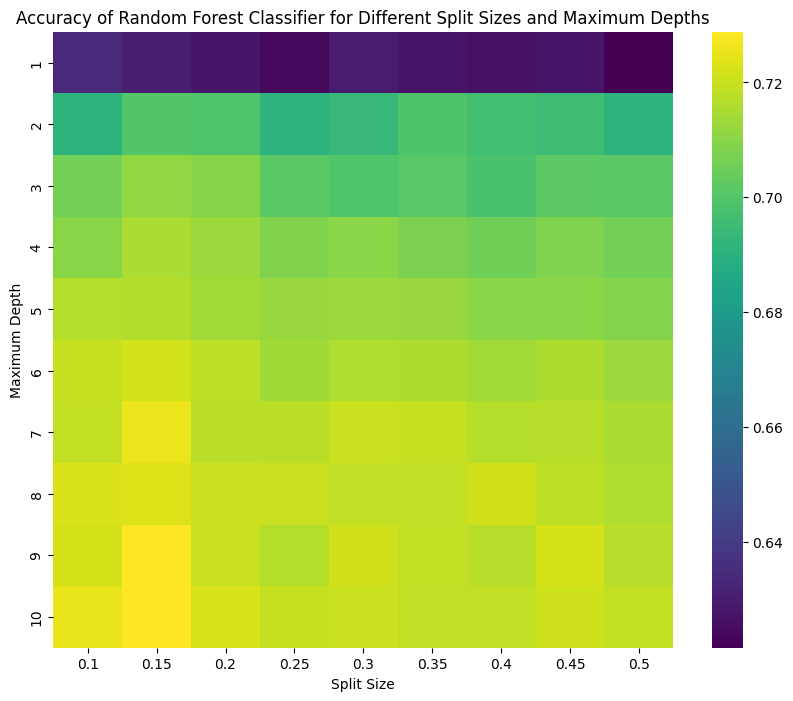

In [ ]:
# Define the split sizes and max depths to be tested
split_sizes = np.around(np.linspace(0.1, 0.5, 9), decimals=2)
max_depths = list(range(1, 11))

# Initialize a dictionary to store the accuracies
accuracy_scores = {}

# For each split size
for split_size in split_sizes:
    accuracy_scores[split_size] = []

    # For each max depth
    for max_depth in max_depths:
        # Perform the split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=25)

        # Train a Random Forest classifier
        clf = RandomForestClassifier(max_depth=max_depth, random_state=25)
        clf.fit(X_train, y_train)

        # Predict on the test set
        y_test_pred = clf.predict(X_test)

        # Compute the accuracy on the test set
        accuracy = accuracy_score(y_test, y_test_pred)

        # Store the accuracy
        accuracy_scores[split_size].append(accuracy)

# Convert the accuracies to a DataFrame
accuracy_df = pd.DataFrame(accuracy_scores, index=max_depths)

# Create a heatmap of the accuracies
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_df, cmap='viridis')
plt.xlabel('Split Size')
plt.ylabel('Maximum Depth')
plt.title('Accuracy of Random Forest Classifier for Different Split Sizes and Maximum Depths')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (20,5), dpi=900)
for i in range(0, 3):
    tree.plot_tree(clf.estimators_[i],
                   max_depth=3,
                   feature_names = X.columns,
                   class_names=True,
                   impurity=True,
                   filled = True,
                   fontsize=3,
                   ax = axes[i]);

**Random Forest with Validation Sets**

In [ ]:
# Split the data into training+validation set and test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=25)

# Further split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=25)

In [ ]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=25)

# Train the classifier on the training set
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=25)

In [ ]:
# Make predictions on the validation set
y_val_pred = clf.predict(X_val)

# Evaluate the model on the validation set
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Validation Accuracy:  0.7158751696065129

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.53      0.60      1505
           1       0.72      0.84      0.78      2180

    accuracy                           0.72      3685
   macro avg       0.71      0.69      0.69      3685
weighted avg       0.71      0.72      0.71      3685


Validation Confusion Matrix:
 [[ 800  705]
 [ 342 1838]]


In [ ]:
# Make predictions on the test set
y_test_pred = clf.predict(X_test)

# Evaluate the model on the test set
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Test Accuracy:  0.7209554831704669

Test Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.52      0.60      1483
           1       0.73      0.85      0.79      2201

    accuracy                           0.72      3684
   macro avg       0.72      0.69      0.69      3684
weighted avg       0.72      0.72      0.71      3684


Test Confusion Matrix:
 [[ 778  705]
 [ 323 1878]]


**Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'n_estimators': np.arange(1, 201),
            'max_depth': np.arange(1,21),
            'min_samples_split': np.arange(1, 51)
}

In [ ]:
randomized_search = RandomizedSearchCV(RandomForestClassifier(random_state=25), param_distributions = parameters, scoring='accuracy',
                                      cv = 5, verbose =True)

In [ ]:
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=25),
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                                        'min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                                        'n_estimators...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200])},
                   scoring='accuracy', verbose=True)

In [ ]:
randomized_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=46, n_estimators=176,
                       random_state=25)

In [ ]:
new_clf = randomized_search.best_estimator_
new_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=46, n_estimators=176,
                       random_state=25)

In [ ]:
new_rf_val_pred = new_clf.predict(X_val)
print('Validation Accuracy: ', metrics.accuracy_score(y_val, new_rf_val_pred))
new_rf_test_pred = new_clf.predict(X_test)
print('Testing Accuracy: ', metrics.accuracy_score(y_test, new_rf_test_pred))

Validation Accuracy:  0.7822769953051644
Testing Accuracy:  0.7280130293159609


In [ ]:
# Split the data into training+validation set and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.075, random_state=25)

# Split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.075, random_state=25)

In [ ]:
new_clf = RandomForestClassifier(max_depth=18, min_samples_split=33, n_estimators=198,
                       random_state=25)
new_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, min_samples_split=33, n_estimators=198,
                       random_state=25)

In [ ]:
new_rf_val_pred = new_clf.predict(X_val)
print('Validation Accuracy: ', metrics.accuracy_score(y_val, new_rf_val_pred))
new_rf_test_pred = new_clf.predict(X_test)
print('Testing Accuracy: ', metrics.accuracy_score(y_test, new_rf_test_pred))

Validation Accuracy:  0.6971830985915493
Testing Accuracy:  0.7252985884907709


Validation Accuracy:  0.7245590230664858

Testing Accuracy:  0.7225841476655809


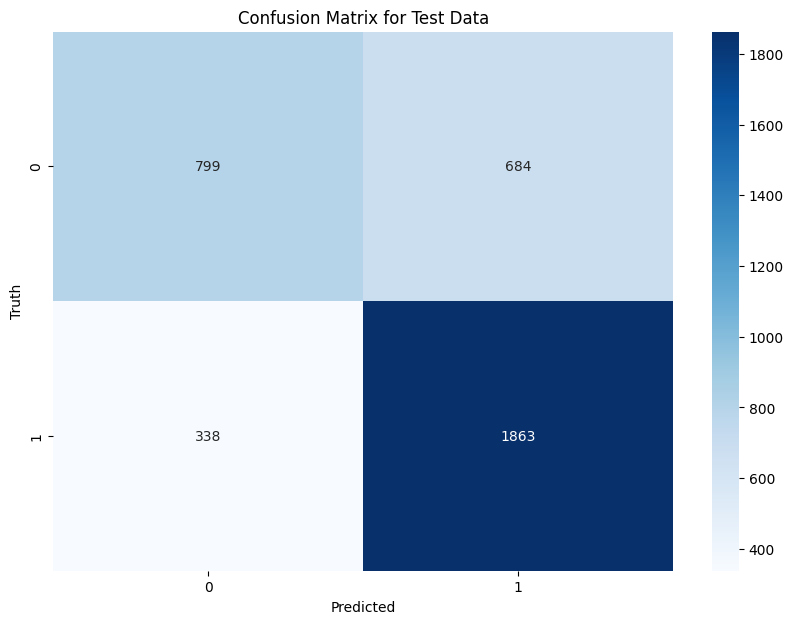

In [ ]:
# Predict on the validation set
new_rf_val_pred = new_clf.predict(X_val)

# Compute and print the accuracy on the validation set
print('Validation Accuracy: ', metrics.accuracy_score(y_val, new_rf_val_pred))

# Predict on the test set
new_rf_test_pred = new_clf.predict(X_test)

# Compute and print the accuracy on the test set
print('\nTesting Accuracy: ', metrics.accuracy_score(y_test, new_rf_test_pred))

# Compute the confusion matrix on the test set
test_confusion_matrix = confusion_matrix(y_test, new_rf_test_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for Test Data')
plt.show()

Validation Accuracy:  0.729160012775471

Testing Accuracy:  0.7239413680781759


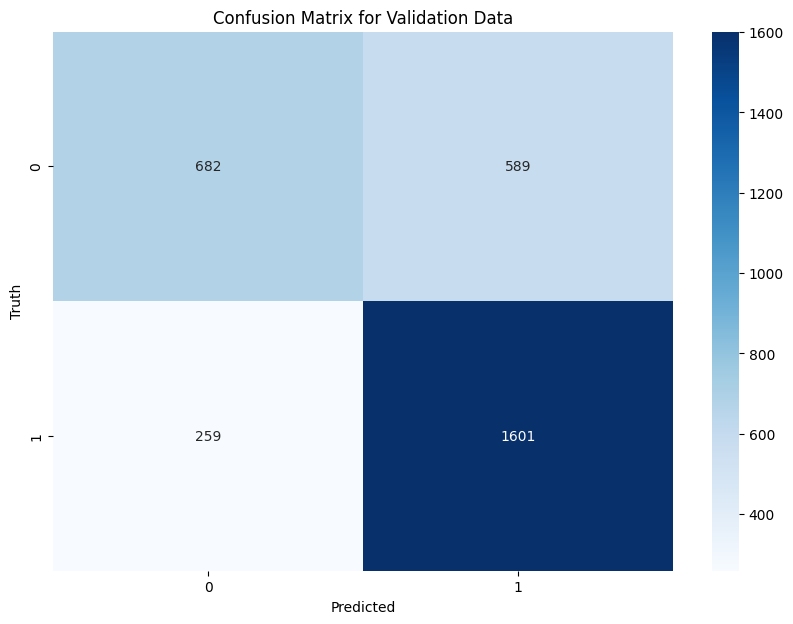

In [ ]:
# Predict on the validation set
new_rf_val_pred = new_clf.predict(X_val)

# Compute and print the accuracy on the validation set
print('Validation Accuracy: ', metrics.accuracy_score(y_val, new_rf_val_pred))

# Predict on the test set
new_rf_test_pred = new_clf.predict(X_test)

# Compute and print the accuracy on the test set
print('\nTesting Accuracy: ', metrics.accuracy_score(y_test, new_rf_test_pred))

# Compute the confusion matrix on the validation set
val_confusion_matrix = confusion_matrix(y_val, new_rf_val_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(val_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for Validation Data')
plt.show()

**Visualization of Hyperparameters**

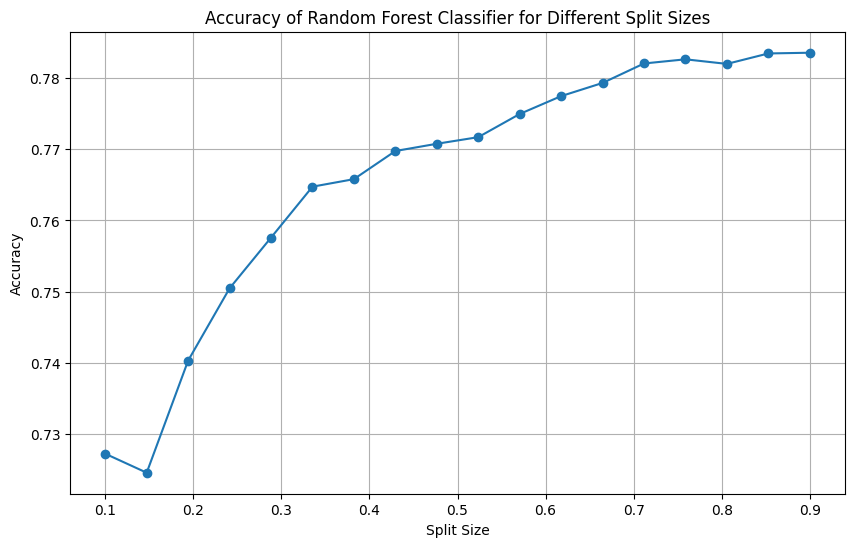

In [ ]:
# Define the split sizes to be tested
split_sizes = np.linspace(0.1, 0.9, 18)

# Initialize a list to store the accuracies
accuracies = []

# For each split size
for split_size in split_sizes:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=25)

    # Make predictions on the test set
    y_test_pred = new_clf.predict(X_test)

    # Compute the accuracy
    accuracy = accuracy_score(y_test, y_test_pred)

    # Store the accuracy
    accuracies.append(accuracy)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(split_sizes, accuracies, marker='o')
plt.title('Accuracy of Random Forest Classifier for Different Split Sizes')
plt.xlabel('Split Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

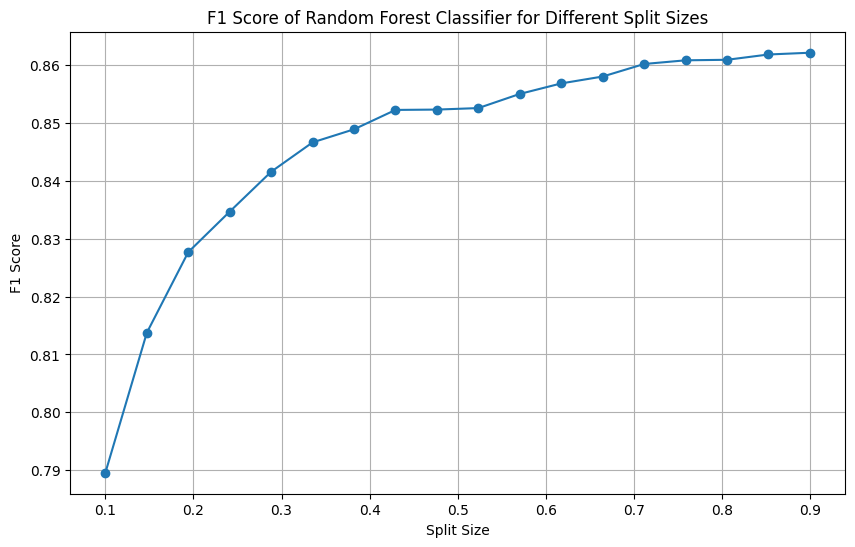

In [ ]:
# Define the split sizes to be tested
split_sizes = np.linspace(0.1, 0.9, 18)

# Initialize a list to store the F1 scores
f1_scores = []

# For each split size
for split_size in split_sizes:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=25)

    # Make predictions on the test set
    y_test_pred = new_clf.predict(X_test)

    # Compute the F1 score
    f1 = f1_score(y_test, y_test_pred)

    # Store the F1 score
    f1_scores.append(f1)

# Plot the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(split_sizes, f1_scores, marker='o')
plt.title('F1 Score of Random Forest Classifier for Different Split Sizes')
plt.xlabel('Split Size')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

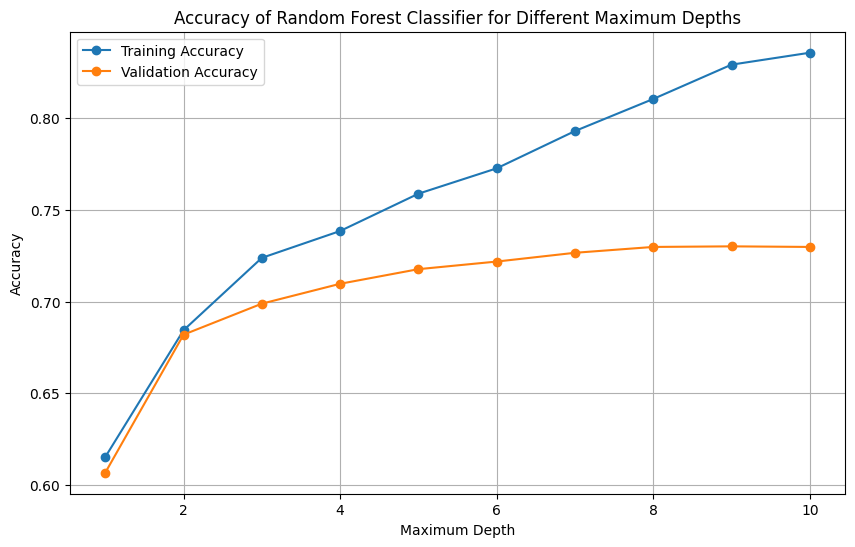

In [ ]:
# Define the maximum depth values
max_depths = list(range(1, 11))

# Initialize lists to store the accuracies
train_accuracies = []
val_accuracies = []

# For each maximum depth
for max_depth in max_depths:
    # Train a Random Forest classifier
    clf = RandomForestClassifier(max_depth=max_depth, min_samples_split=22, n_estimators=178,
                       random_state=25)
    clf.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = clf.predict(X_train)

    # Compute the accuracy on the training set
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Make predictions on the validation set
    y_val_pred = clf.predict(X_val)

    # Compute the accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Store the accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(max_depths, val_accuracies, marker='o', label='Validation Accuracy')
plt.title('Accuracy of Random Forest Classifier for Different Maximum Depths')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()